<a href="https://colab.research.google.com/github/shreyab375/Wind-Turbine-Project/blob/main/Wind_Turbine_Project_2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement :** Imagine a company wants to expand its services to the wind industry (wind turbines) and gives
you free rein to decide on what to do and how to do it. The company has seen that Engie has an
open data set available online and Engie’s head of Wind Turbines has agreed to take a
meeting with the company in 2 weeks out of curiosity. The company has given you one week to take this
dataset and make the best out of it. The goal is to prove that given this type of data, ML can
create value for a player like Engie. We expect that by the end of the week you can give a
technical presentation to your colleagues at the same company on what results you achieved, how you
achieved them and what interesting aspects you would have researched if you had more
time - first from a technical perspective - and then finally suggest how we can use these
results to convince Engie’s Head of Wind Turbines in the following week.

**Identified Business Problem Statement:**
Maximize the power output of wind turbines by optimizing operational parameters, primarily the pitch angle, and other influencing factors.

**Approach to Solution:**
Develop a regression model to predict wind turbine power output (Active_power) based on various operational parameters. Utilize datetime information, and operational variables such as pitch angle, reactive power, nacelle angle, nacelle temperature, wind speed, absolute wind direction, rotor speed, rotor bearing temperature, and torque as predictor variables. Train the model on the given data to optimize the pitch angle and other operational parameters for maximizing power output. Use the regression model to provide real-time recommendations for adjusting operational parameters to optimize power output.

In [1]:
#Import the required packages
#Import the required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
wt1 = pd.read_csv('/content/drive/MyDrive/R80711.csv', header =0)
wt2 = pd.read_csv('/content/drive/MyDrive/R80721.csv')
wt3 = pd.read_csv('/content/drive/MyDrive/R80736.csv')
wt4 = pd.read_csv('/content/drive/MyDrive/R80790.csv')

In [3]:
# Combining all the dataframes to one to have a long dataset
wt = pd.concat([wt1, wt2, wt3, wt4], axis =0)

In [4]:
wt.head()

,Date_time,Date_time_nr,Wind_turbine_name,Ba_avg,P_avg,Q_avg,Ya_avg,Yt_avg,Ws1_avg,Ws2_avg,...,Rs_avg,Rbt_avg,Rm_avg,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h
0,2013-01-01T00:00:00+01:00,1356994800,R80711,-1.00,1072.6500,14.490000,161.44000,12.730000,8.770001,9.160000,...,17.18,28.709999,5690.2798,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
1,2013-01-01T00:10:00+01:00,1356995400,R80711,-1.00,1061.4301,23.700001,161.44000,14.990000,8.660000,9.120000,...,17.17,28.700001,5632.7202,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
2,2013-01-01T00:20:00+01:00,1356996000,R80711,-1.00,1144.7900,25.480000,161.44000,21.750000,8.940000,9.450000,...,17.18,28.790001,6071.6899,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
3,2013-01-01T00:30:00+01:00,1356996600,R80711,-1.00,1183.9800,24.379999,173.41000,23.799999,8.870000,8.979999,...,17.18,28.860001,6279.4702,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
4,2013-01-01T00:40:00+01:00,1356997200,R80711,-0.98,1317.5500,14.470000,177.89999,17.910000,9.440000,9.510000,...,17.18,28.770000,6988.5698,5.39,1011.0,75.0,5.66,180.0,0.0,0.0


In [5]:
#Filter the columns needed
wt = wt[["Date_time","P_avg","wind_speed","wind_deg","temp","Ba_avg","Q_avg","Ya_avg","Yt_avg","Wind_turbine_name","Rs_avg","Rbt_avg","Rm_avg"]]

##Feature Engineering on the Date Time Column:
Extracting relevant features from the date-time data that can capture time-related patterns and trends. Some common features that can be extracted from date-time data include:

- Hour of the day
- Day of the week
- Month
- Season
- Year
- Period of the day (morning, afternoon, evening, night)

In [6]:
# Try to convert the column to datetime, ignoring errors
try:
    wt['Date_time'] = pd.to_datetime(wt['Date_time'], errors='coerce', utc = True)
except Exception as e:
    print(f"Error converting column 'datetime': {e}")
# Convert Date_time column to datetime format
#wt['Date_time'] = pd.to_datetime(wt['Date_time'])

In [7]:
errored_rows = wt['Date_time'].isna().sum()
print(f"Number of errored rows: {errored_rows}")

Number of errored rows: 0


In [8]:
# Extract features
wt['Hour_of_day'] = wt['Date_time'].dt.hour
wt['Day_of_week'] = wt['Date_time'].dt.dayofweek
wt['Month'] = wt['Date_time'].dt.month
wt['Year'] = wt['Date_time'].dt.year

In [9]:
# Define function to get season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


In [10]:
# Apply function to get season
wt['Season'] = wt['Month'].apply(get_season)

In [11]:
# Create one-hot encodings for the 'Season' and 'Period_of_day' and 'Wind_turbine_name' columns
season_dummies = pd.get_dummies(wt['Season'], prefix='Season',  dtype =int)

# Concatenate the one-hot encoded columns with the original DataFrame
wt = pd.concat([wt, season_dummies], axis=1)


##Exploratory Data Analysis

In [12]:
wt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1045835 entries, 0 to 261413
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   Date_time          1045835 non-null  datetime64[ns, UTC]
 1   P_avg              1045835 non-null  float64            
 2   wind_speed         1045835 non-null  float64            
 3   wind_deg           1045835 non-null  float64            
 4   temp               1045835 non-null  float64            
 5   Ba_avg             1045835 non-null  float64            
 6   Q_avg              1045835 non-null  float64            
 7   Ya_avg             1045835 non-null  float64            
 8   Yt_avg             1045835 non-null  float64            
 9   Wind_turbine_name  1045835 non-null  object             
 10  Rs_avg             1045835 non-null  float64            
 11  Rbt_avg            1045835 non-null  float64            
 12  Rm_avg             1

In [13]:
wt.describe()

,P_avg,wind_speed,wind_deg,temp,Ba_avg,Q_avg,Ya_avg,Yt_avg,Rs_avg,Rbt_avg,Rm_avg,Hour_of_day,Day_of_week,Month,Year,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
count,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06,1.045835e+06
mean,3.387389e+02,3.496396e+00,1.720753e+02,1.084260e+01,1.328076e+01,2.711905e+01,1.818058e+02,2.444940e+01,1.021237e+01,2.726109e+01,1.997247e+03,1.149463e+01,3.005890e+00,6.479978e+00,2.015010e+03,2.467990e-01,2.508837e-01,2.493472e-01,2.529701e-01
std,4.319955e+02,2.162061e+00,9.964680e+01,7.557704e+00,2.760354e+01,3.016313e+01,9.481130e+01,6.909388e+00,5.814546e+00,6.287116e+00,2.278944e+03,6.928842e+00,1.998407e+00,3.468926e+00,1.426061e+00,4.311489e-01,4.335219e-01,4.326353e-01,4.347142e-01
min,-1.849000e+01,1.300000e-01,0.000000e+00,-1.070000e+01,-1.212600e+02,-1.969500e+02,0.000000e+00,-2.732000e+02,0.000000e+00,-2.732000e+02,-9.554600e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.426000e+01,2.060000e+00,8.700000e+01,5.130000e+00,-9.900000e-01,2.490000e+00,9.878000e+01,2.023000e+01,9.229999e+00,2.420000e+01,1.253000e+02,5.000000e+00,1.000000e+00,3.000000e+00,2.014000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.733200e+02,3.090000e+00,1.900000e+02,1.039000e+01,-9.700000e-01,2.206000e+01,2.002100e+02,2.505000e+01,1.130000e+01,2.796000e+01,1.370710e+03,1.100000e+01,3.000000e+00,7.000000e+00,2.015000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.823450e+02,4.630000e+00,2.400000e+02,1.602000e+01,3.800000e+00,3.625000e+01,2.504900e+02,2.919000e+01,1.499000e+01,3.130000e+01,2.890605e+03,1.800000e+01,5.000000e+00,9.000000e+00,2.016000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,2.051870e+03,1.903000e+01,3.600000e+02,3.594000e+01,2.626100e+02,2.667000e+02,3.600000e+02,5.609000e+01,1.722000e+01,1.335500e+02,1.087570e+04,2.300000e+01,6.000000e+00,1.200000e+01,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


<Axes: xlabel='Season_Autumn', ylabel='wind_speed'>

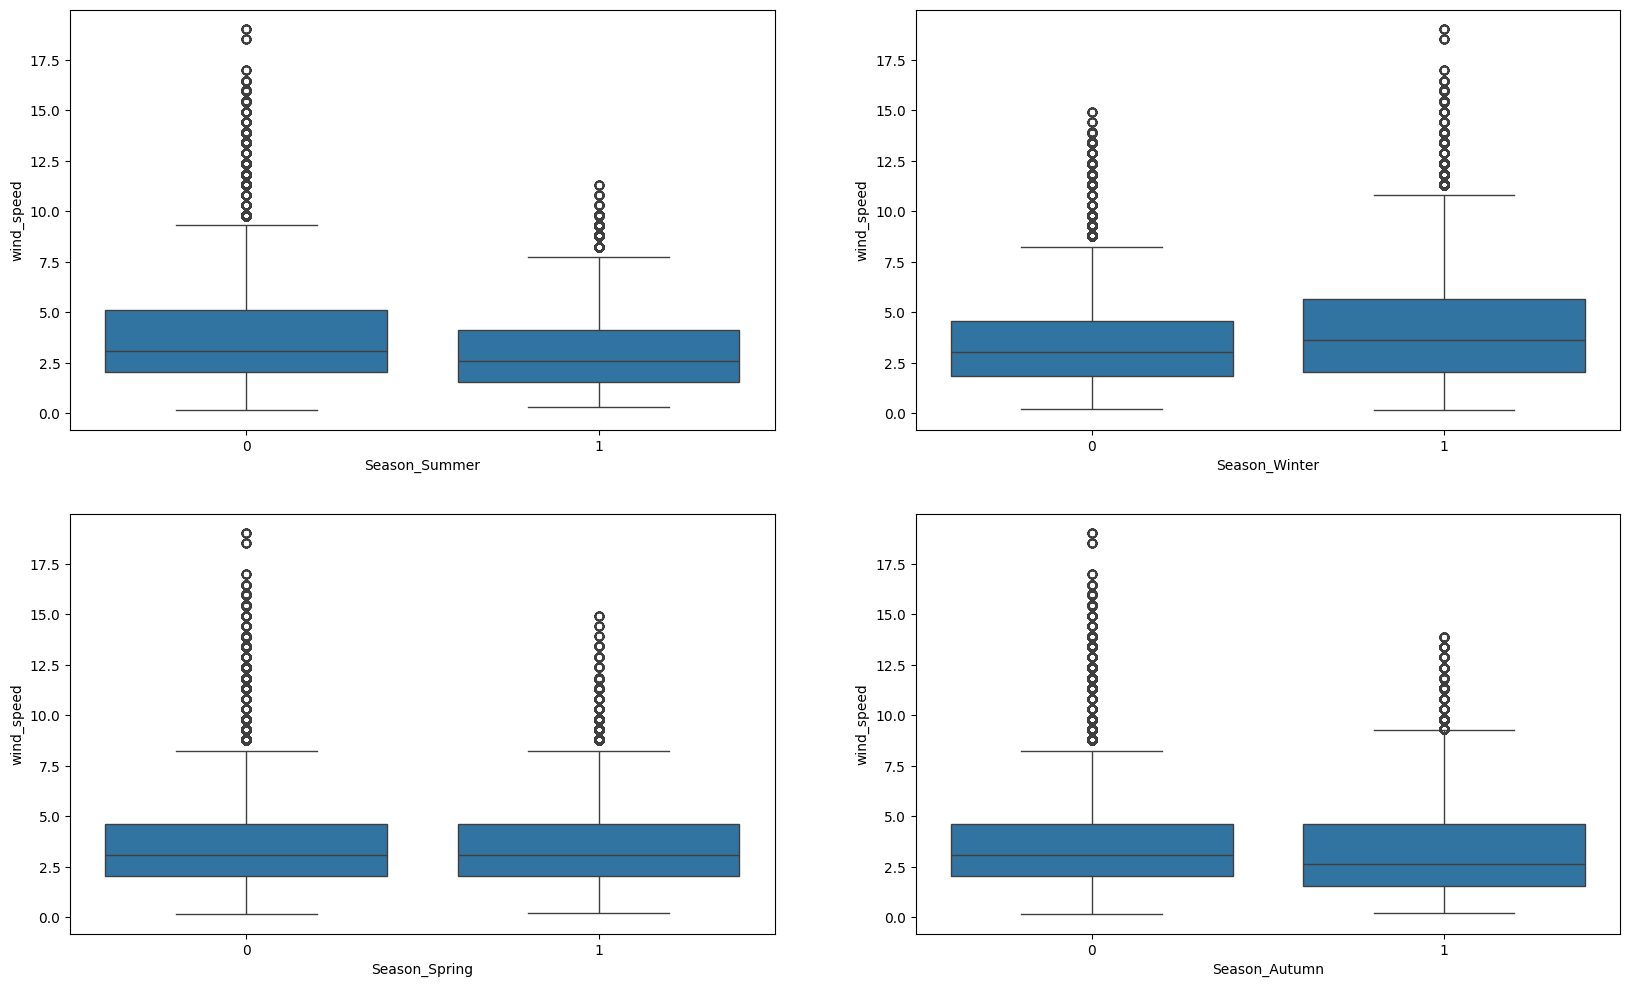

In [14]:
#Checking for Outliers on some important parameters like wind speed
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'Season_Summer', y = 'wind_speed', data = wt)
plt.subplot(2,2,2)
sns.boxplot(x = 'Season_Winter', y = 'wind_speed', data = wt)
plt.subplot(2,2,3)
sns.boxplot(x = 'Season_Spring', y = 'wind_speed', data = wt)
plt.subplot(2,2,4)
sns.boxplot(x = 'Season_Autumn', y = 'wind_speed', data = wt)

<Axes: xlabel='Season_Autumn', ylabel='wind_deg'>

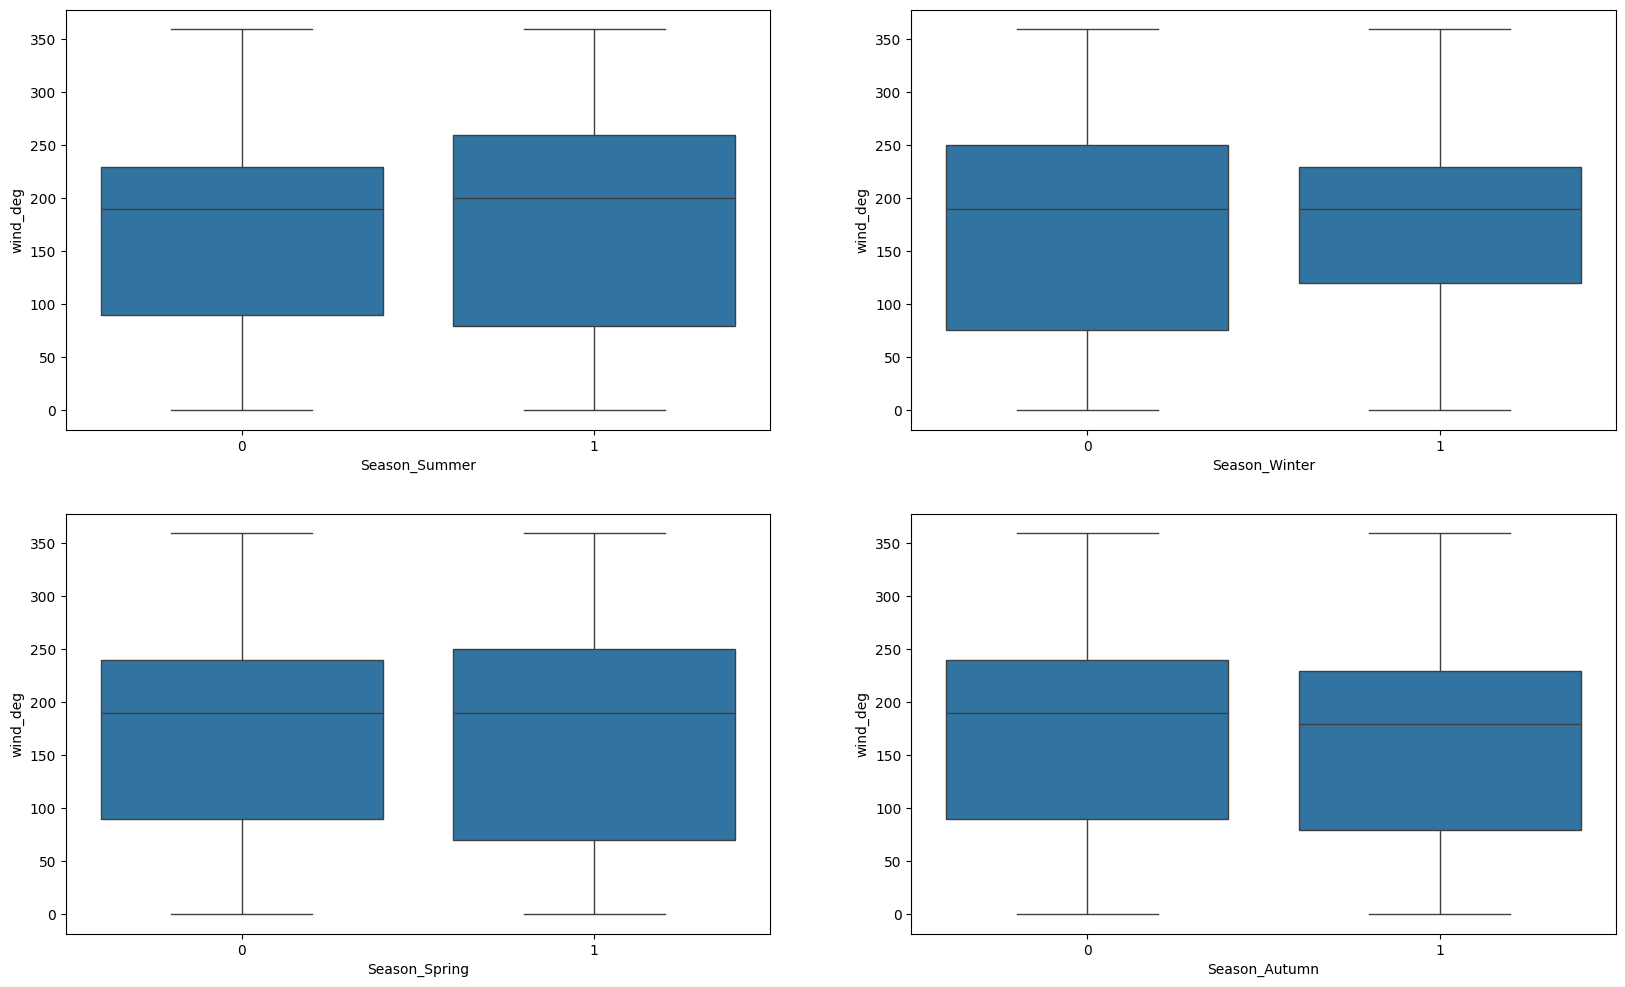

In [15]:
#Checking for Outliers on some important parameters like wind speed
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'Season_Summer', y = 'wind_deg', data = wt)
plt.subplot(2,2,2)
sns.boxplot(x = 'Season_Winter', y = 'wind_deg', data = wt)
plt.subplot(2,2,3)
sns.boxplot(x = 'Season_Spring', y = 'wind_deg', data = wt)
plt.subplot(2,2,4)
sns.boxplot(x = 'Season_Autumn', y = 'wind_deg', data = wt)

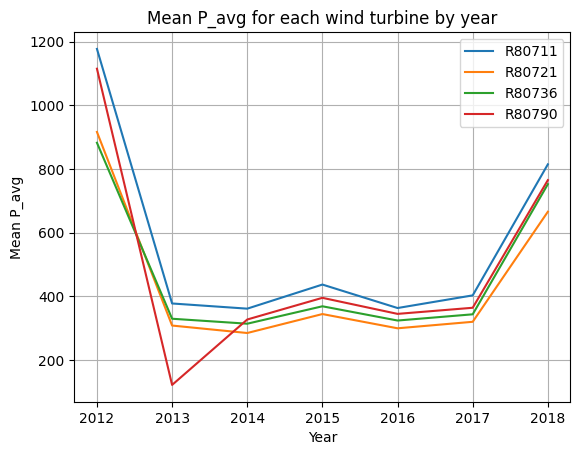

In [16]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'P_avg' for each group
grouped_data = wt.groupby(['Wind_turbine_name', 'Year'])['P_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Wind_turbine_name'):
    plt.plot(group['Year'], group['P_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean P_avg')
plt.title('Mean P_avg for each wind turbine by year')
plt.legend()
plt.grid(True)
plt.show()

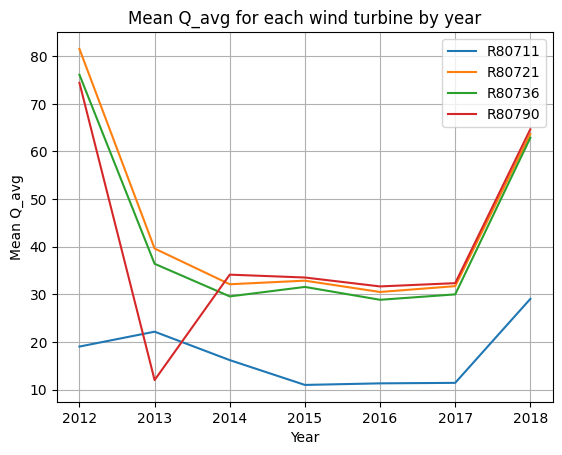

In [17]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Wind_turbine_name', 'Year'])['Q_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Wind_turbine_name'):
    plt.plot(group['Year'], group['Q_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Q_avg')
plt.title('Mean Q_avg for each wind turbine by year')
plt.legend()
plt.grid(True)
plt.show()

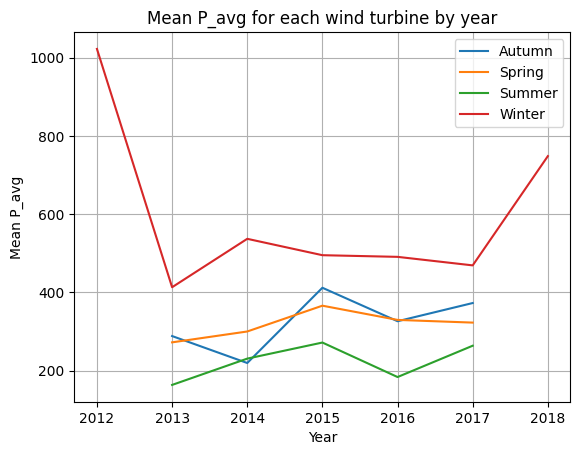

In [18]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['P_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['P_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean P_avg')
plt.title('Mean P_avg for each wind turbine by year')
plt.legend()
plt.grid(True)
plt.show()

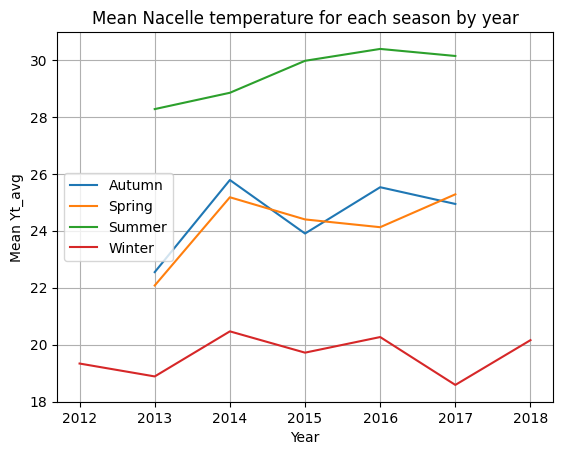

In [19]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['Yt_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['Yt_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Yt_avg')
plt.title('Mean Nacelle temperature for each season by year')
plt.legend()
plt.grid(True)
plt.show()

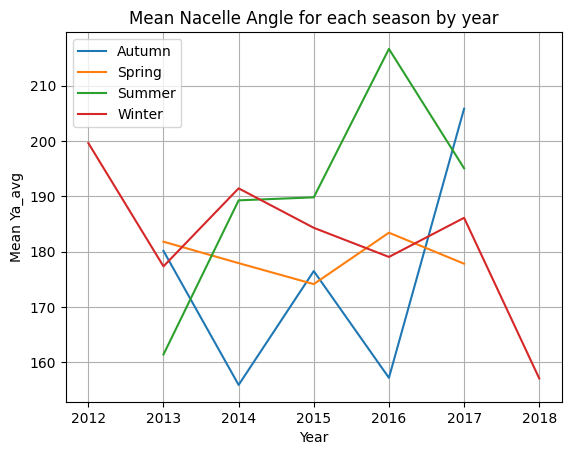

In [20]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['Ya_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['Ya_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Ya_avg')
plt.title('Mean Nacelle Angle for each season by year')
plt.legend()
plt.grid(True)
plt.show()

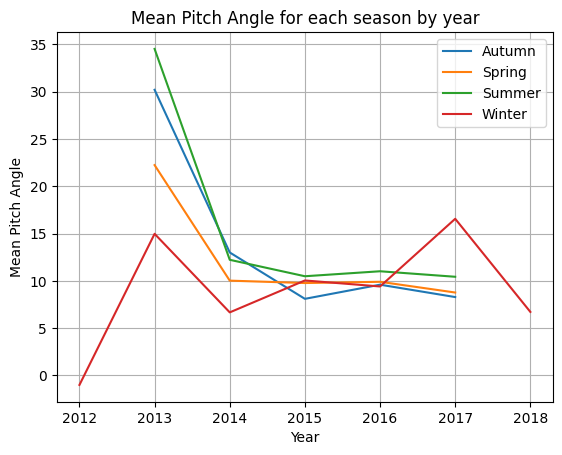

In [21]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['Ba_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['Ba_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Pitch Angle')
plt.title('Mean Pitch Angle for each season by year')
plt.legend()
plt.grid(True)
plt.show()

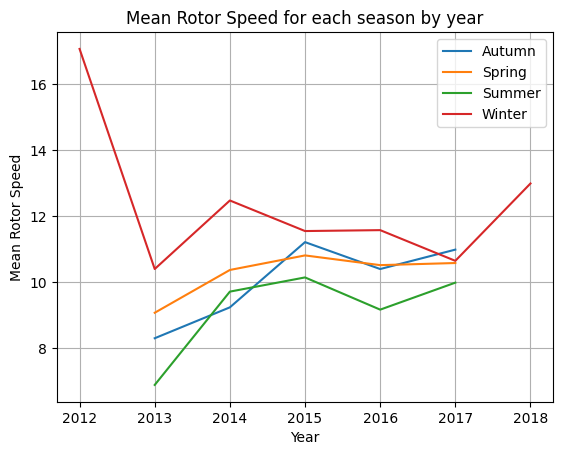

In [22]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['Rs_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['Rs_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Rotor Speed')
plt.title('Mean Rotor Speed for each season by year')
plt.legend()
plt.grid(True)
plt.show()

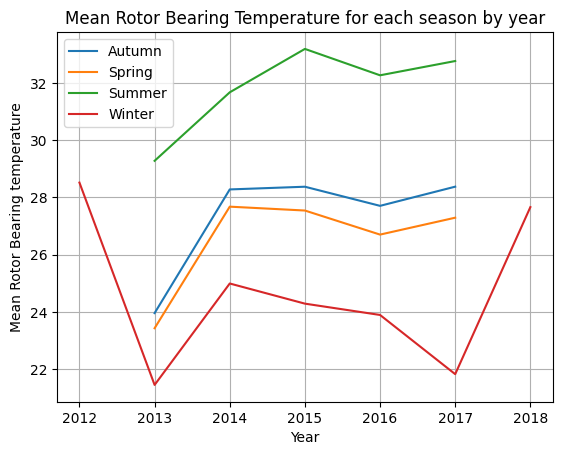

In [23]:
# Group data by 'Wind_turbine_name' and 'Year', calculate the mean of 'Q_avg' for each group
grouped_data = wt.groupby(['Season', 'Year'])['Rbt_avg'].mean().reset_index()

# Plotting
for turbine_name, group in grouped_data.groupby('Season'):
    plt.plot(group['Year'], group['Rbt_avg'], label=turbine_name)

plt.xlabel('Year')
plt.ylabel('Mean Rotor Bearing temperature')
plt.title('Mean Rotor Bearing Temperature for each season by year')
plt.legend()
plt.grid(True)
plt.show()

Since a strong seasonal fluctuation can be observed, the next step would be to incorporate time series analysis. However, for now I tried regression models to get the optimum outputs

In [24]:
# Since the visualization is done let's drop the object typed variables such as Season, Windmill_name etc
# Drop the original 'Season' and 'Period_of_day' columns
wt.drop(['Season','Wind_turbine_name', 'Date_time'], axis=1, inplace=True)

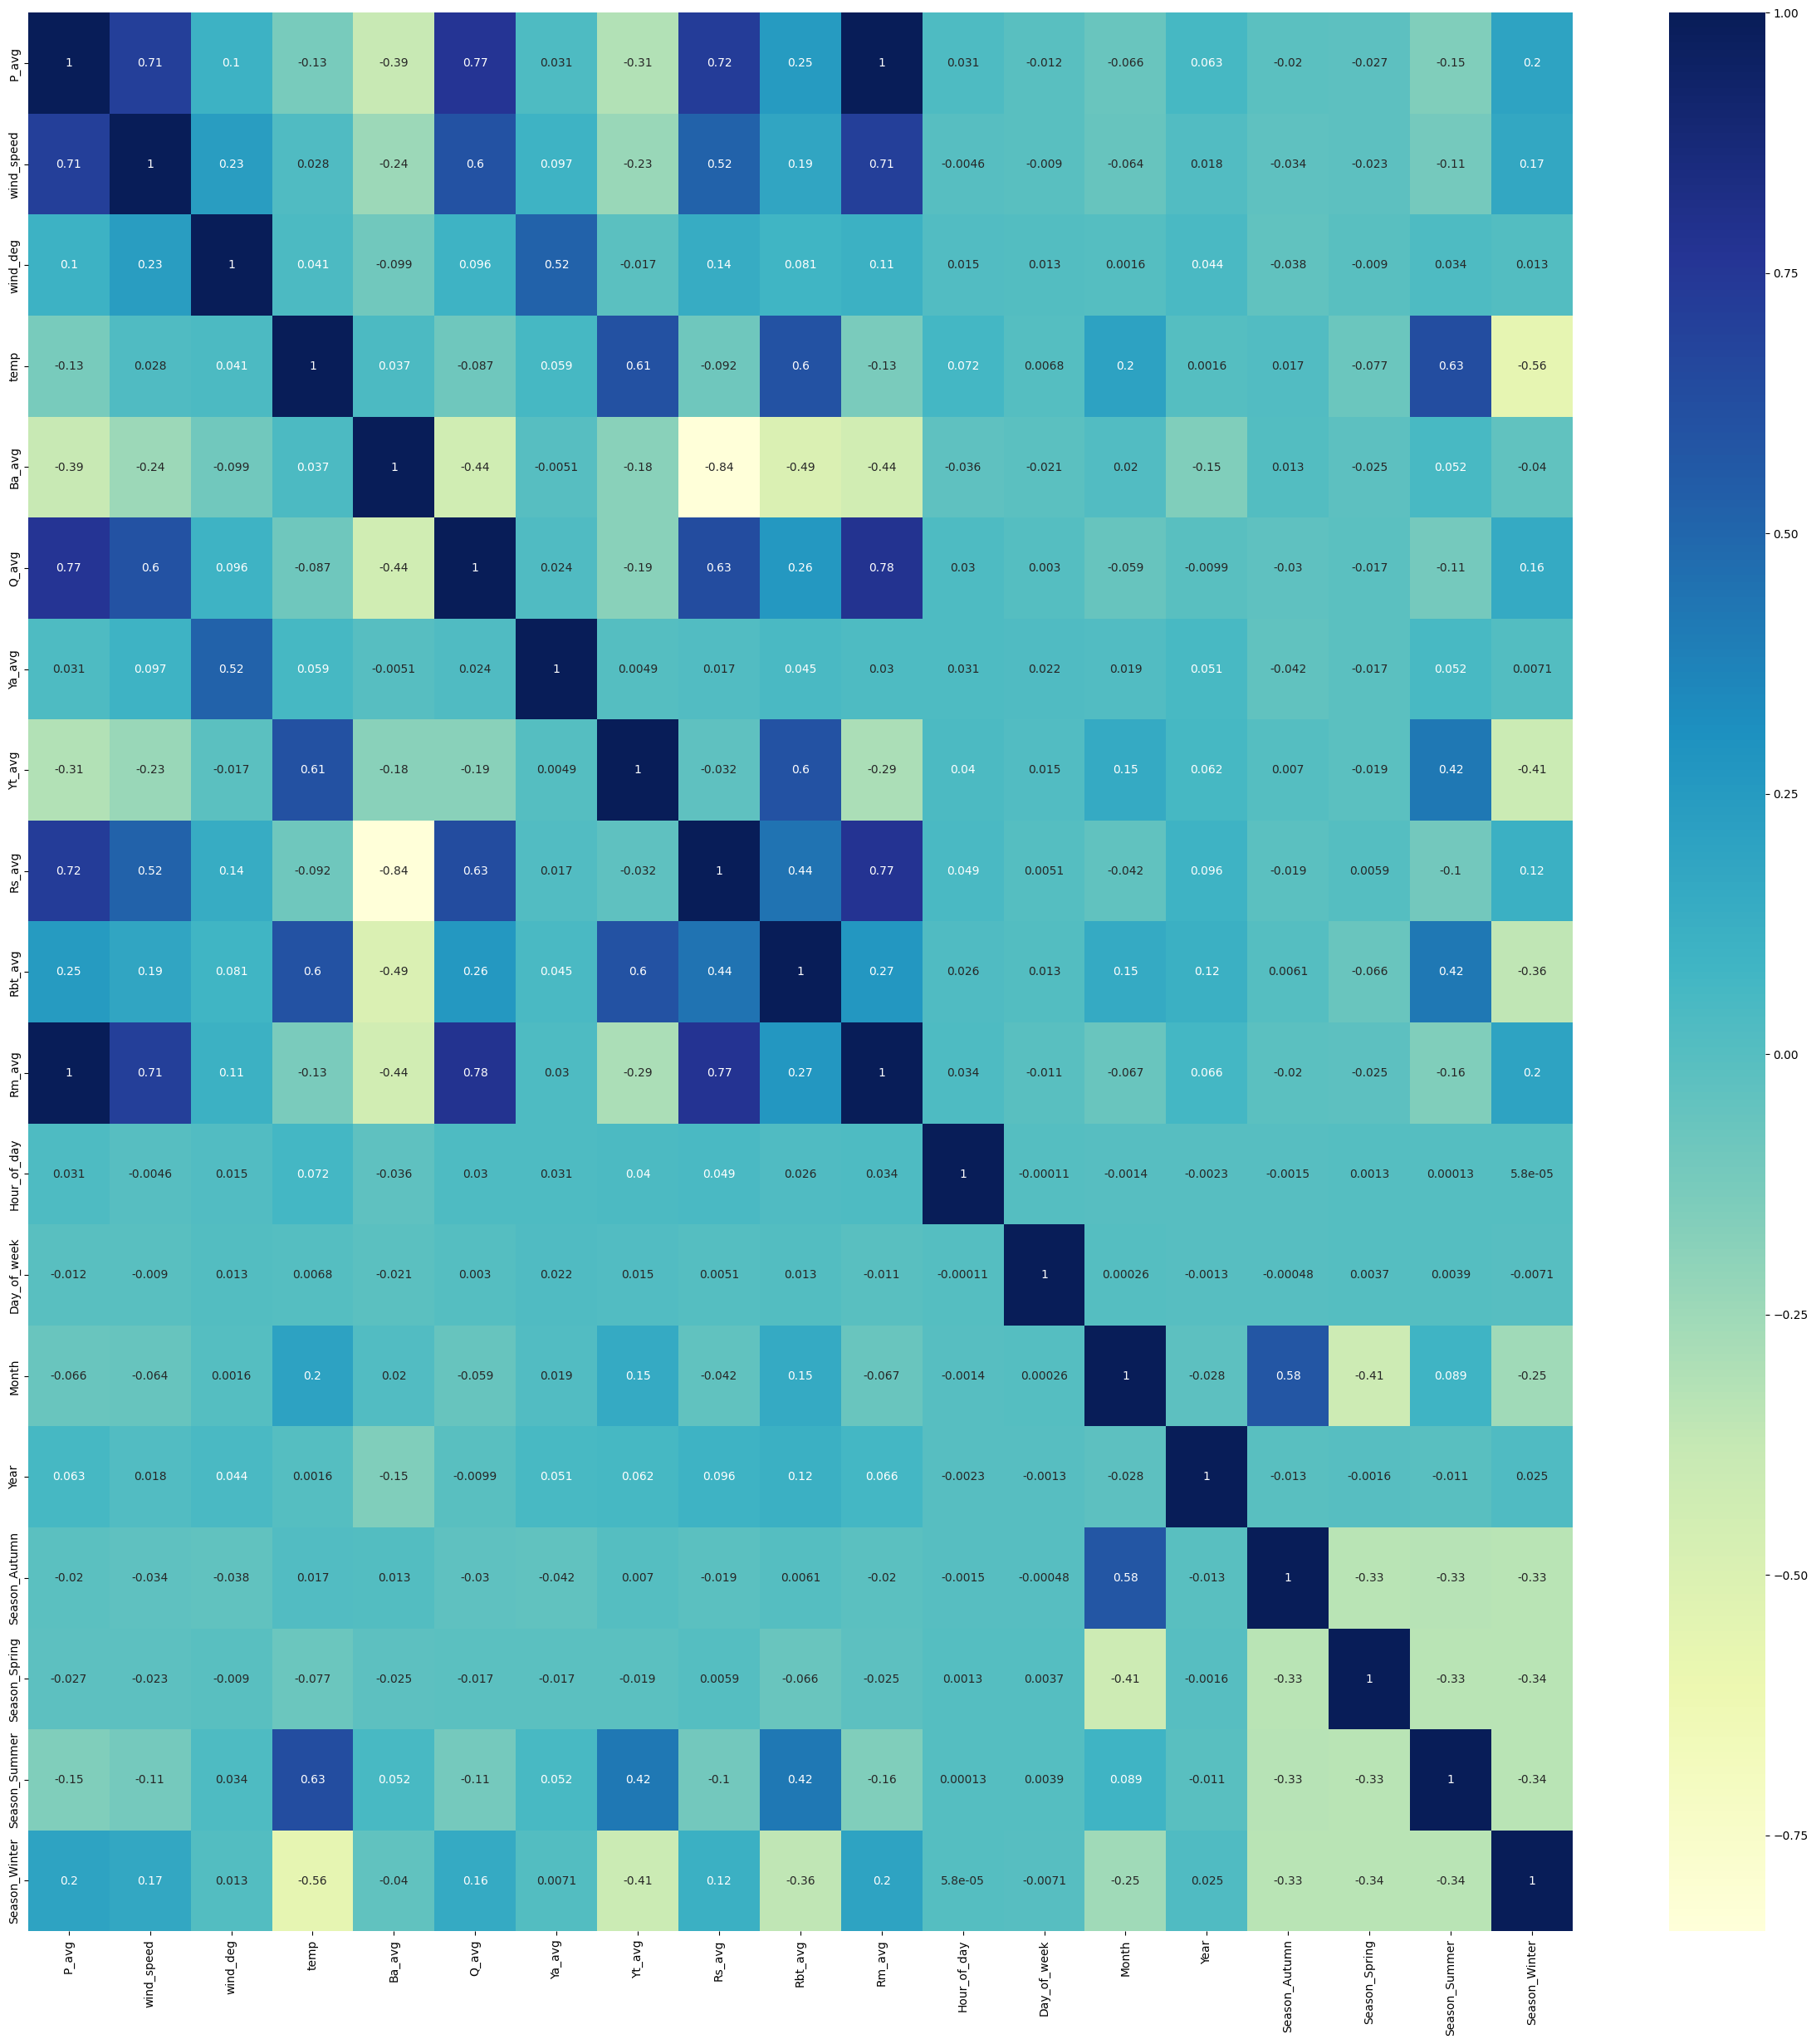

In [25]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (30, 30))
sns.heatmap(wt.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [26]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(wt, train_size = 0.8, test_size = 0.2, random_state = 100)

# Scaling the data
Scaling techniques are essential preprocessing steps in machine learning to normalize or standardize the features of a dataset. They ensure that features are on a similar scale, preventing certain features from dominating others due to their larger magnitude. One commonly used scaling technique is the Min-Max Scaler.
- **Min-Max Scaler**: This scaler rescales features to a specified range, typically between 0 and 1. It works by subtracting the minimum value of the feature and then dividing by the range of values (i.e., maximum value minus minimum value). It is suitable for algorithms sensitive to the magnitude of features, such as neural networks and algorithms using distance-based metrics.

- **Standard Scaler (Z-score normalization)**: This scaler scales features to have a mean of 0 and a standard deviation of 1. It works by subtracting the mean of the feature and then dividing by the standard deviation. It is suitable for algorithms that assume normally distributed features, such as linear regression, logistic regression, and SVMs.

- ** Robust Scaler**: This scaler is robust to outliers in the data. It scales features using the interquartile range (IQR), making it suitable for datasets with outliers.

- **Max Abs Scaler**: This scaler scales features to the maximum absolute value, making the maximum absolute value of each feature 1. It is useful when the magnitude of features is unknown or varies widely.

- **Quantile Transformer Scaler**: This scaler transforms features to follow a Gaussian distribution using quantile information. It is robust to outliers and ensures that the transformed data has a more Gaussian-like distribution.

Here I have used Min-Max scalar

In [27]:
scaler = MinMaxScaler()

In [28]:
df_train.columns

Index(['P_avg', 'wind_speed', 'wind_deg', 'temp', 'Ba_avg', 'Q_avg', 'Ya_avg',
       'Yt_avg', 'Rs_avg', 'Rbt_avg', 'Rm_avg', 'Hour_of_day', 'Day_of_week',
       'Month', 'Year', 'Season_Autumn', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')

In [29]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['P_avg', 'wind_speed', 'wind_deg', 'temp', 'Ba_avg', 'Q_avg', 'Ya_avg',
       'Yt_avg', 'Rs_avg', 'Rbt_avg', 'Rm_avg', 'Hour_of_day', 'Day_of_week',
       'Month', 'Year',]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [30]:
df_transform = df_train.copy()

##**Feature Selection for Regression Model for Predicting Active Power (P)**
Feature selection for linear regression involves choosing a subset of relevant features from the dataset to improve model performance and interpretability. Here are some common techniques for feature selection in linear regression:
- **Correlation Analysis**: Calculate the correlation coefficients between each feature and the target variable. Features with high correlation values (either positive or negative) are likely to be more relevant.

- **Recursive Feature Elimination (RFE):** RFE is an iterative technique that recursively removes the least important feature from the dataset until the specified number of features is reached. It uses the model's coefficients or feature importances to determine feature importance.

- **Forward or Backward Selection:** These methods start with an empty set of features (forward selection) or the full set of features (backward selection) and iteratively add or remove features based on their impact on model performance.

- **Lasso Regression (L1 Regularization)**: Lasso regression adds a penalty term to the linear regression objective function, which penalizes the absolute magnitude of the coefficients. This leads to some coefficients being exactly zero, effectively performing feature selection.

- **Feature Importance from Tree-based Models**: If your dataset contains a large number of features, you can train a tree-based model (e.g., Random Forest) and use feature importances to identify the most important features.

- **Principal Component Analysis (PCA)**: PCA is a dimensionality reduction technique that can be used to transform the original features into a smaller set of orthogonal components. These components can then be used as input features for linear regression.

-  **Variance Inflation Factor (VIF)**: Pairwise correlation helps understand relationships between independent variables, but for complex dependencies, Variance Inflation Factor (VIF) is crucial. VIF measures how well a variable is explained by others, identifying multicollinearity. With VIF > 10, eliminating variables is imperative; VIF > 5 requires inspection, while VIF < 5 indicates a valuable variable. In feature selection, combinations of high p-values and VIF, low p-values and VIF, or mixed values guide decisions. Prioritize dropping variables with high p-values and low VIF, followed by those with low p-values and high VIF. This systematic approach optimizes model efficiency and accuracy by handling multicollinearity effectively.

*Due to time constraint I used only RFE*


In [31]:
y_train = df_train.pop('P_avg')
X_train = df_train

y_test = df_test.pop("P_avg")
X_test = df_test


In [32]:
model = LinearRegression()
# Initialize RFE with the linear regression model
# Specify the number of desired features to select (n_features_to_select)
rfe = RFE(model, n_features_to_select=18)
rfe = rfe.fit(X_train, y_train)

In [33]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [34]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('wind_speed', True, 1),
 ('wind_deg', True, 1),
 ('temp', True, 1),
 ('Ba_avg', True, 1),
 ('Q_avg', True, 1),
 ('Ya_avg', True, 1),
 ('Yt_avg', True, 1),
 ('Rs_avg', True, 1),
 ('Rbt_avg', True, 1),
 ('Rm_avg', True, 1),
 ('Hour_of_day', True, 1),
 ('Day_of_week', True, 1),
 ('Month', True, 1),
 ('Year', True, 1),
 ('Season_Autumn', True, 1),
 ('Season_Spring', True, 1),
 ('Season_Summer', True, 1),
 ('Season_Winter', True, 1)]

In [35]:
#Getting the column names from x_train to implement on X_test
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index([], dtype='object')

In [36]:
X_train = X_train[col]
X_test = X_test[col]

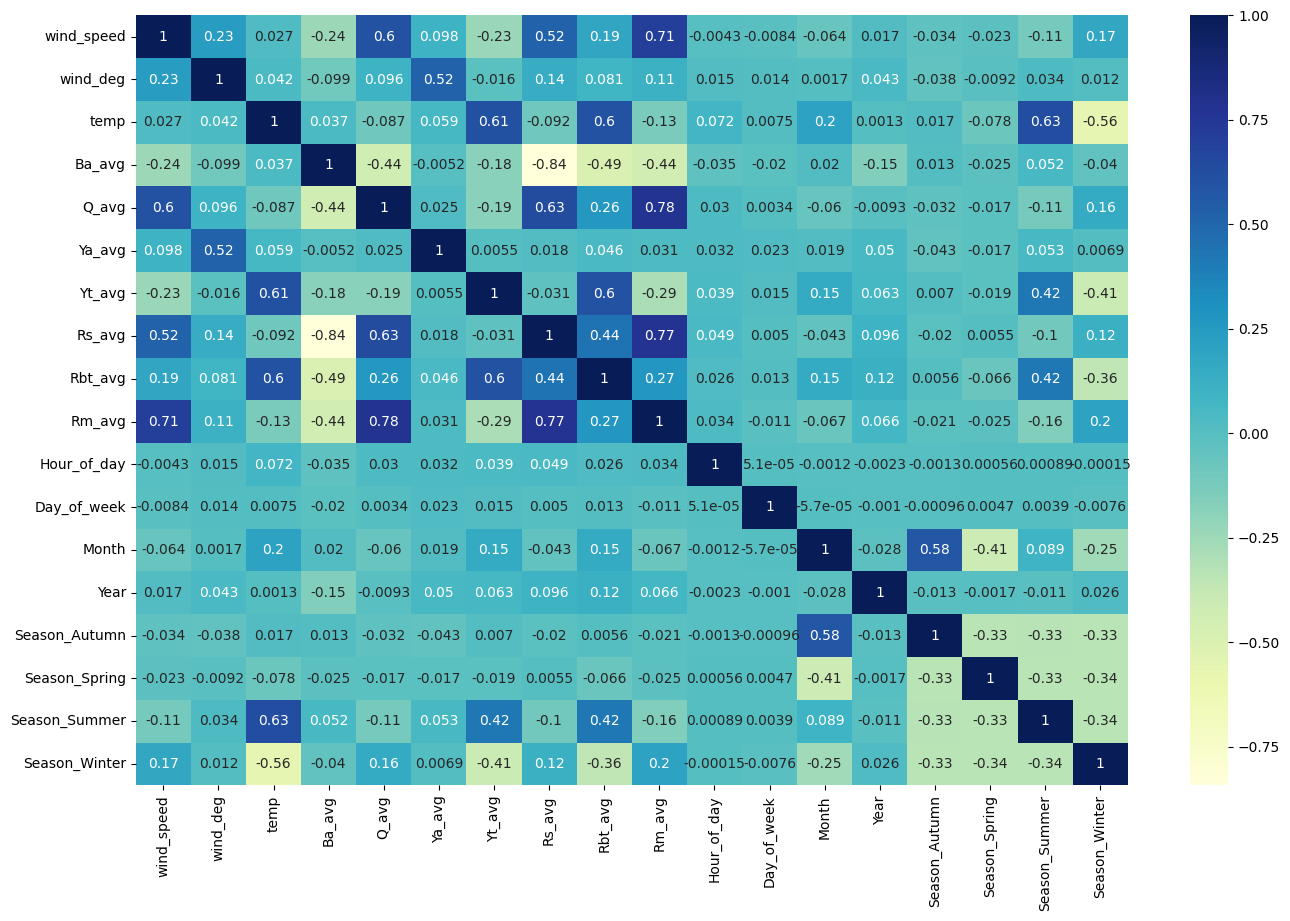

In [37]:
# Let's check the correlation coefficients to see if the correlations have been taken care of

plt.figure(figsize = (16, 10))
sns.heatmap(X_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

These 4 variables not adding much value so decided to drop it as the seasonal patterns are more important than daily patterns

In [38]:
X_train = X_train.drop(columns = ["Hour_of_day", "Day_of_week","Month", "Year"])
X_test = X_test.drop(columns = ["Hour_of_day", "Day_of_week","Month", "Year"])

In [39]:
#creating a dataframe to store every value from every model
metric = pd.DataFrame()

# Linear Regression

In [40]:
model = LinearRegression()
# Fit a line
model.fit(X_train, y_train)

LinearRegression()

In [41]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [42]:
#Metric evaluations
#R-Squared
r2_train = r2_score(y_train, y_train_pred)
r2_test =  r2_score(y_test, y_test_pred)

#Adjusted R2
ad_r2_train = 1 - ((1 - r2_train) * (len(y_train) - 1) / (len(y_train) - 15 - 1)) # Since we have 20 features
ad_r2_test = 1 - ((1 - r2_test) * (len(y_test) - 1) / (len(y_test) - 15 - 1)) # Since we have 20 features


# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)


# Calculate MAPE
#mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
#mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

df = pd.DataFrame({"Method": "Simple Linear Regression","R2(Train)": r2_train,"R2(Test)": r2_test,"Adjusted_R2(Train)": ad_r2_train,"Adjusted_R2(Test)": ad_r2_test,"Mean Absolute Error(Train)": mae_train,"Mean Absolute Error(Test)": mae_test,"Mean Squared Error(Train)": mse_train,"Mean Squared Error(Test)": mse_test,"Root Mean Squared Error(Train)": rmse_train,"Root Mean Squared Error(Test)": rmse_test}, index = [1])
metric = metric._append(df)
#"MAPE(Train)": mape_train,"MAPE(Test)": mape_test

In [43]:
metric

,Method,R2(Train),R2(Test),Adjusted_R2(Train),Adjusted_R2(Test),Mean Absolute Error(Train),Mean Absolute Error(Test),Mean Squared Error(Train),Mean Squared Error(Test),Root Mean Squared Error(Train),Root Mean Squared Error(Test)
1,Simple Linear Regression,0.996251,0.996245,0.996251,0.996245,0.01071,0.010717,0.000163,0.000163,0.012777,0.012783


# Decision tree

In [44]:
dt = DecisionTreeRegressor()

In [45]:
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [47]:
#Metric evaluations
#R-Squared
r2_train = r2_score(y_train, y_train_pred)
r2_test =  r2_score(y_test, y_test_pred)

#Adjusted R2
ad_r2_train = 1 - ((1 - r2_train) * (len(y_train) - 1) / (len(y_train) - 15 - 1))
ad_r2_test = 1 - ((1 - r2_test) * (len(y_test) - 1) / (len(y_test) - 15 - 1))


# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)


# Calculate MAPE
#mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
#mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

df = pd.DataFrame({"Method": "Decision Tree","R2(Train)": r2_train,"R2(Test)": r2_test,"Adjusted_R2(Train)": ad_r2_train,"Adjusted_R2(Test)": ad_r2_test,"Mean Absolute Error(Train)": mae_train,"Mean Absolute Error(Test)": mae_test,"Mean Squared Error(Train)": mse_train,"Mean Squared Error(Test)": mse_test,"Root Mean Squared Error(Train)": rmse_train,"Root Mean Squared Error(Test)": rmse_test}, index = [1])
metric = metric._append(df)
#"MAPE(Train)": mape_train,"MAPE(Test)": mape_test

In [48]:
metric

,Method,R2(Train),R2(Test),Adjusted_R2(Train),Adjusted_R2(Test),Mean Absolute Error(Train),Mean Absolute Error(Test),Mean Squared Error(Train),Mean Squared Error(Test),Root Mean Squared Error(Train),Root Mean Squared Error(Test)
1,Simple Linear Regression,0.996251,0.996245,0.996251,0.996245,1.070989e-02,0.010717,1.632578e-04,0.000163,0.012777,0.012783
1,Decision Tree,1.000000,0.999945,1.000000,0.999945,1.195928e-07,0.000676,3.494397e-11,0.000002,0.000006,0.001546


# Random Forest

In [49]:
rf = RandomForestRegressor()

In [50]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [51]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [52]:
#Metric evaluations
#R-Squared
r2_train = r2_score(y_train, y_train_pred)
r2_test =  r2_score(y_test, y_test_pred)

#Adjusted R2
ad_r2_train = 1 - ((1 - r2_train) * (len(y_train) - 1) / (len(y_train) - 15 - 1)) # Since we have 18 features
ad_r2_test = 1 - ((1 - r2_test) * (len(y_test) - 1) / (len(y_test) - 15 - 1)) # Since we have 18 features


# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)


# Calculate MAPE
#mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
#mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

df = pd.DataFrame({"Method": "Random Forest","R2(Train)": r2_train,"R2(Test)": r2_test,"Adjusted_R2(Train)": ad_r2_train,"Adjusted_R2(Test)": ad_r2_test,"Mean Absolute Error(Train)": mae_train,"Mean Absolute Error(Test)": mae_test,"Mean Squared Error(Train)": mse_train,"Mean Squared Error(Test)": mse_test,"Root Mean Squared Error(Train)": rmse_train,"Root Mean Squared Error(Test)": rmse_test}, index = [1])
metric = metric._append(df)
#"MAPE(Train)": mape_train,"MAPE(Test)": mape_test

In [53]:
metric

,Method,R2(Train),R2(Test),Adjusted_R2(Train),Adjusted_R2(Test),Mean Absolute Error(Train),Mean Absolute Error(Test),Mean Squared Error(Train),Mean Squared Error(Test),Root Mean Squared Error(Train),Root Mean Squared Error(Test)
1,Simple Linear Regression,0.996251,0.996245,0.996251,0.996245,1.070989e-02,0.010717,1.632578e-04,0.000163,0.012777,0.012783
1,Decision Tree,1.000000,0.999945,1.000000,0.999945,1.195928e-07,0.000676,3.494397e-11,0.000002,0.000006,0.001546
1,Random Forest,0.999996,0.999967,0.999996,0.999967,1.802889e-04,0.000485,1.880532e-07,0.000001,0.000434,0.001192


In [54]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_})

In [55]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
9,Rm_avg,9.998314e-01
7,Rs_avg,9.020784e-05
2,temp,3.215098e-05
3,Ba_avg,2.568227e-05
8,Rbt_avg,5.825039e-06
4,Q_avg,4.202486e-06
0,wind_speed,3.614899e-06
6,Yt_avg,2.756183e-06
5,Ya_avg,1.921598e-06
1,wind_deg,1.377953e-06


## Function to Retrieve the input variables from a given Desired output given the weather conditions like wind speed and wind direction

In [56]:
optimal_params = pd.DataFrame(df_transform)
optimal_params["P_avg"] = y_train_pred
num_vars = ['P_avg','wind_speed', 'wind_deg', 'temp', 'Ba_avg', 'Q_avg', 'Ya_avg',
       'Yt_avg', 'Rs_avg', 'Rbt_avg', 'Rm_avg', 'Hour_of_day', 'Day_of_week',
       'Month', 'Year',]
optimal_params[num_vars] = scaler.inverse_transform(optimal_params[num_vars])

In [57]:
import numpy as np

def find_closest_match(df, wind_speed, wind_deg, desired_power):
    # Filter rows based on wind speed
    df_filtered = df[(df['wind_speed'] >= wind_speed - 10) & (df['wind_speed'] <= wind_speed + 10)]

    # Filter rows based on wind direction
    df_filtered = df_filtered[(df_filtered['wind_deg'] >= wind_deg - 10) & (df_filtered['wind_deg'] <= wind_deg + 10)]

    # Calculate absolute difference between predicted power and desired power for each row
    df_filtered['power_difference'] = np.abs(df_filtered['P_avg'] - desired_power)
    min = df_filtered['power_difference'].min()
    # Find row with minimum absolute difference
    closest_match = df_filtered.loc[df_filtered['power_difference']==min]

    return closest_match



In [58]:
# Example usage
wind_speed_input = float(input("Enter the wind speed: "))
wind_deg_input = float(input("Enter the wind direction: "))
desired_power_input = float(input("Enter the desired power: "))
closest_match_row = find_closest_match(optimal_params, wind_speed_input, wind_deg_input, desired_power_input)
print("Closest match row:")
print(closest_match_row)


Enter the wind speed: 6
Enter the wind direction: 60
Enter the desired power: 1000
Closest match row:
             P_avg  wind_speed  wind_deg   temp  Ba_avg  Q_avg  Ya_avg  \
227114  999.981396        5.14      70.0  12.86   -0.99  -1.66   55.98   

           Yt_avg  Rs_avg    Rbt_avg     Rm_avg  Hour_of_day  Day_of_week  \
227114  17.969999    17.1  28.709999  5321.0298         18.0          4.0   

        Month    Year  Season_Autumn  Season_Spring  Season_Summer  \
227114    5.0  2017.0              0              1              0   

        Season_Winter  power_difference  
227114              0          0.018604  


**Conclusion:**

The results obtained from our machine learning analysis demonstrate the immense potential of leveraging predictive models to optimize wind turbine power output. The high accuracy and efficiency of our models, as indicated by the evaluation metrics, underscore the value of incorporating machine learning into wind turbine operations.

The Simple Linear Regression, Decision Tree, and Random Forest models have all exhibited exceptional performance, achieving R2 scores exceeding 99.6% on both training and testing datasets. This indicates that our models can effectively predict power output based on various operational parameters, such as pitch angle, reactive power, nacelle angle, temperature, wind speed, rotor speed, and rotor bearing temperature.

Furthermore, the feature importance analysis reveals key insights into the factors that most strongly influence power output. The dominance of variables such as average torque (Rm_avg) highlights the critical role of operational parameters in maximizing turbine performance.

Moreover, our analysis has uncovered a strong seasonality trend, indicating that power output varies significantly based on the time of year. **This suggests that incorporating time series analysis and seasonality modeling into our predictive models could further enhance their accuracy and effectiveness.**

In conclusion, the adoption of machine learning techniques offers a strategic advantage for wind turbine operators seeking to optimize power output and maximize operational efficiency. By harnessing the power of data-driven insights, we can provide real-time recommendations for adjusting operational parameters, ultimately leading to increased energy production and improved profitability. We recommend embracing machine learning as a key component of wind turbine management strategies to stay ahead in the renewable energy industry.

Example Function to optimize the exact output of the Input variables Further

In [59]:
def find_optimal_input(desired_power, model):
    # Define input variable ranges and increment steps
    input_ranges = {
        'Ba_avg': (-100, 100, 1),
        'Yt_avg': (-20, 40, 1),
        'wind_speed': (0, 100, 1),
        'wind_deg': (0, 360, 1),
        'temp': (-10, 40, 1),
        'Rm_avg': (-125, 200, 1),
        'Rs_avg': (20, 100, 1),
        'Rbt_avg': (-200, 300, 1),
        'Q_avg': (-100, 300, 1),
        'Ya_avg': (0, 360, 1),
        'Season_Summer': (0, 1, 1),
        'Season_Winter': (0, 1, 1),
        'Season_Spring': (0, 1, 1),
        'Season_Autumn': (0, 1, 1),
        # Add more input variables as needed
    }

    # Initialize input values with the lowest range value
    input_values = {variable: min_value for variable, (min_value, _, _) in input_ranges.items()}

    # Prompt the user for input values
    for variable, (min_value, max_value, increment) in input_ranges.items():
        user_input = input(f"Enter the value for {variable} (range: {min_value} to {max_value}, increment: {increment}, press Enter for default value of {min_value}): ")
        if user_input:
            input_values[variable] = float(user_input)

    # Iterate to find optimal input values
    while True:
        # Predict power output using current input values
        predicted_power = model.predict([[input_values[variable] for variable in input_ranges.keys()]])[0]

        # Check if predicted power matches desired power within a tolerance
        if abs(predicted_power - desired_power) < 100:  # Adjust tolerance as needed
            break  # Exit loop if desired power is reached

        # Adjust input values based on the difference between predicted and desired power
        for variable, (min_value, max_value, increment) in input_ranges.items():
            if predicted_power < desired_power:
                if input_values[variable] + increment <= max_value:
                    input_values[variable] += increment
            else:
                if input_values[variable] - increment >= min_value:
                    input_values[variable] -= increment

    return input_values





In [60]:

model = model


# Desired power output provided by the user
desired_power = float(input("Enter the desired power output: "))

# Find optimal input values
optimal_input_values = find_optimal_input(desired_power, model)
print("Optimal Input Values:", optimal_input_values)


KeyboardInterrupt: Interrupted by user